<a href="https://colab.research.google.com/github/Jharvin3/Neural-Network-License-Plate-Recognition/blob/main/MFMLAI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network: License Plate Recognition

By: Michelle Gore, Jamaine Harvin, and Alsion Tafa

# Objective

 The primary goal is to create a Neural Network that reads out the numbers and letters from a license plate image.


In [ ]:
!pip install tensorflow
!pip install opencv-python

In [ ]:

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Reshape, BatchNormalization, Softmax
from tensorflow.keras import Model, datasets, layers, models, Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


TensorFlow version: 2.17.1


In [ ]:
import kagglehub

path = kagglehub.dataset_download("nickyazdani/license-plate-text-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/nickyazdani/license-plate-text-recognition-dataset/versions/1


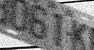

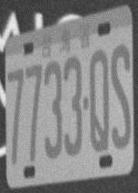

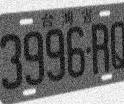

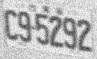

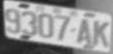

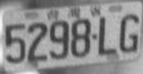

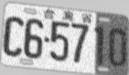

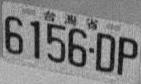

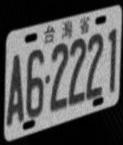

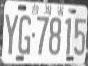

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os


image_files = os.listdir(path)

image_files = os.listdir(os.path.join(path, 'cropped_lps', 'cropped_lps'))

greyimages = []

#Check if any image files were found
if not image_files:
    print("No image files found in the directory.")
else:
     #Construct the full path to the images
    images = [os.path.join(path, 'cropped_lps', 'cropped_lps',  file)for file in image_files]

    #converting images to greyscale
    for image_path in images:
      greyimages.append(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY))


    for greyimage in greyimages[:10]:
        cv2_imshow(greyimage)


    # Check if the image loaded successfully
        #if showimage is not None:
        # Showing image
          #cv2_imshow(showimage)
        #else:
          #print(f"Failed to load image from {image_path}")




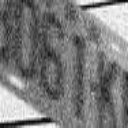

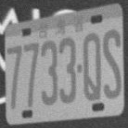

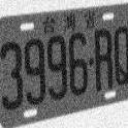

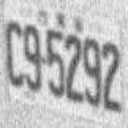

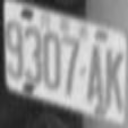

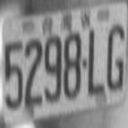

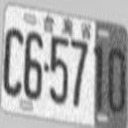

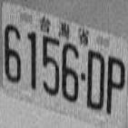

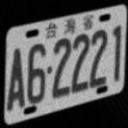

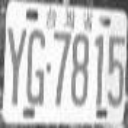

In [ ]:
#resizing the images we originally attempted padding the images but it was to computational expensive so we switched to resizing the images smaller.

#loop thourgh image array and find the largest width and the largest height, then scale the rest of the images to that size using cv2.copyMakeBorder()
#max_height=0
#ax_width=0
#paddedgreyimages = []
#for greyimage in greyimages:
#        height, width = greyimage.shape
#        if height>max_height:
#          max_height = height
#        if width>max_width:
#          max_width = width
#for greyimage in greyimages:
#        height, width = greyimage.shape
#        paddedgreyimages.append(cv2.copyMakeBorder(greyimage, max_height-height, 0, max_width-width, 0, cv2.BORDER_CONSTANT, value = 0))
#for paddedgreyimage in paddedgreyimages[:5]:
#        cv2_imshow(paddedgreyimage)
#        height, width = paddedgreyimage.shape
#        print(height)
#        print(width)

images=[]
image_size = (128, 128)
for greyimage in greyimages:
      images.append(cv2.resize(greyimage, image_size))

for image in images[:10]:
        cv2_imshow(image)

In [ ]:

#flattened_images = [paddedgreyimage.flatten() / 255.0 for paddedgreyimage in paddedgreyimages[:150]]
#flattened_test_images = [paddedgreyimage.flatten() / 255.0 for paddedgreyimage in paddedgreyimages[150:190]]

# Assign to x_train and x_test and normalizing images values to be between 0 and 1
x_train = np.array(images[:15000])/255
x_test = np.array(images[15000:19000])/255

#Adding a channel dimension for greyscale
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [ ]:
# Load our CSV file with the lables

csv_path = os.path.join(path, 'lpr.csv')
df = pd.read_csv(csv_path, header=None)
df.columns = ['Index', 'Filename', 'Label']

characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
char_to_idx = {char: idx for idx, char in enumerate(characters)}
num_classes = len(char_to_idx)

all_labels = list(df['Label'])
encoded_labels = [[char_to_idx[char] for char in label.upper()] for label in all_labels]

one_hot_encoded_labels = [
    tf.keras.utils.to_categorical(label, num_classes=num_classes) for label in encoded_labels
]

y_train = np.array(one_hot_encoded_labels[:15000])
y_test = np.array(one_hot_encoded_labels[15000:19000])


In [ ]:
#Checking the shape of the images
print("train images: ", x_train.shape)
print("test images: ", x_test.shape)
print("format: (# images, length, width)")

train images:  (15000, 128, 128, 1)
test images:  (4000, 128, 128, 1)
format: (# images, length, width)


In [ ]:
#Checking the shape of the labels
print("train labels: ", y_train.shape)
print("test labels: ", y_test.shape)
print("format: (# labels, *)")

train labels:  (15000, 6, 36)
test labels:  (4000, 6, 36)
format: (# labels, *)


In [ ]:
#This will create "batches" of images to train on at once.

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(4000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [ ]:
#Building our model. This commented out section was what we had originally attempted before continuing to make changes.
#model = Sequential([
#    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1)),
#    MaxPooling2D((2, 2)),
#    Conv2D(64, (3, 3), activation='relu'),
#    MaxPooling2D((2, 2)),
#    Flatten(),
#   Dense(128, activation='relu'),
#    Dropout(0.5),
#    Dense(6* 36),
#    tf.keras.layers.Reshape((6, 36)),  # Reshape to (6, 36) for 6 character predictions
#    tf.keras.layers.Softmax(axis=-1)
#  ])

model = Sequential([
    # Convolutional layers for feature extraction
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Reduce overfitting

    Dense(216, activation='relu'),
    Dropout(0.5),
    # Output layer: predict the sequence of characters (we eventually realized the difficulty of this and just stuck to identifying the characters)
    Reshape((6, 36)),
    Softmax(axis=-1),

    # Reshape the output into sequence format (6, 36)
    Reshape((6, 36))  # Each character has a probability distribution over 36 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 216)                 │         110,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 216)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 6, 36)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_4 (Softmax)                  │ (None, 6, 36)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,219,672 (19.91 MB)

 Trainable params: 5,218,712 (19.91 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# This sets the optimizer to the Adam algorithm. This is an algorithm to
# calculate the "first order and second order moments" for stochastic
# gradient descent. The learning rate is 0.001.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# We want to see our model's performance as it trains. This will capture the performance.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

#This code below while still work is commented out as we could not achieve results beyond .01%
#on getting all the characters completely in order to the label.

#def license_plate_accuracy(y_true, y_pred):
#    true_classes = tf.argmax(y_true, axis=-1)  # Get true class indices
#    pred_classes = tf.argmax(y_pred, axis=-1)  # Get predicted class indices
#    match = tf.reduce_all(tf.equal(true_classes, pred_classes), axis=-1)  # Check full match
#    return tf.reduce_mean(tf.cast(match, tf.float32))  # Average over the batch

# Example usage: track this metric during training/evaluation
#train_plate_accuracy = tf.keras.metrics.Mean(name='train_plate_accuracy')
#test_plate_accuracy = tf.keras.metrics.Mean(name='test_plate_accuracy')


In [ ]:
#How we will train our model

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
  #train_plate_accuracy(license_plate_accuracy(labels, predictions))


#Take a batch of test images and labels.
#Use the model to make prediction of the labels of the images.
#Calculate the loss and accuracy of the model's predictions.
#adjust the model's parameters to reduce loss and update the models parameters.


In [ ]:
# After it has been trained, this is how we will test the model.

@tf.function
def test_step(images, labels):
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)
  #test_plate_accuracy(license_plate_accuracy(labels, predictions))


#Take a batch of test images and labels.
#Use the trained model to predict the labels for the images.
#Calculate the loss and accuracy of the model's predictions.
#Update the overall test loss and accuracy metrics.

In [ ]:
# Finally, running the model the number of Epochs is how many times it will loop
EPOCHS = 20


train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_state()
  train_accuracy.reset_state()
  test_loss.reset_state()
  test_accuracy.reset_state()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  train_loss_history.append(train_loss.result().numpy())
  train_accuracy_history.append(train_accuracy.result().numpy() * 100)
  test_loss_history.append(test_loss.result().numpy())
  test_accuracy_history.append(test_accuracy.result().numpy() * 100)

  #prints out results per epoch
  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result():0.2f}, '
    f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
    f'Test Loss: {test_loss.result():0.2f}, '
    f'Test Accuracy: {test_accuracy.result() * 100:0.2f}, '
    #f'Train Plate Accuracy: {train_plate_accuracy.result().numpy() * 100:.2f}%, '
    #f'Test Plate Accuracy: {test_plate_accuracy.result().numpy() * 100:.2f}%'
  )


# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(test_accuracy_history, label='Test Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(test_loss_history, label='Test Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1, Loss: 3.40, Accuracy: 7.40, Test Loss: 3.30, Test Accuracy: 7.24, 
Epoch 2, Loss: 3.40, Accuracy: 7.35, Test Loss: 3.30, Test Accuracy: 7.37, 


KeyboardInterrupt: 